### Basic ISC
2023/2024
#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle
from nilearn import plotting, maskers, datasets
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [2]:
#recompute_results      = True
#pairwise_flag          = True
n_iter                 = 1000
alpha                  = 0.05
fmri_data_file         = '../data/03_extract_ts_usa/usa_ts_array_shen268_regional_average_ages13-99.npy'
all268_rois_file       = '../data/02_rois_masks_maps/shen_2mm_268_parcellation.nii'
masker_prefitting_file = '../data/02_rois_masks_maps/maskerprefit_bold.nii.gz'

#isc_result_file_phase  = '../data/05_results/usa_isc_phase1000FDRq05.nii'
#isc_result_file_perm   = '../data/05_results/usa_isc_perm1000_FDRq05.nii'
#isc_npy_file           = '../data/05_results/usa_isc_perm1000_FDRq05.npy'

#### Load timeseries

In [3]:
# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Shape of time series structure: (168, 268, 33)


#### Basic ISC analysis 
(via resampling stats)

100%|█████████████████████████████████████████| 268/268 [01:03<00:00,  4.22it/s]


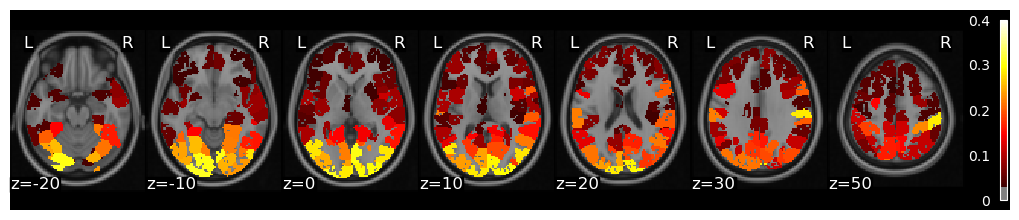

In [4]:
# set up mask
mask = Brain_Data(all268_rois_file)
mask_x = expand_mask(mask)

# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(268)):
    #print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:] )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])

# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img='../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);
